# Shear profile of A360 using Anacal

Xiangchong Li, Prakruth Adari, Anja von der Linden\
LSST Science Piplines version: v29_0_0_rc5\
Container Size: large

This notebook is a condensed set of code to obtain a shear profile of Abell 360 using Anacal shear measurements. The main steps are:

- Loading in Anacal catalogs
- Shear profile
- Mass Map

In [2]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import os, sys
import numpy as np
import astropy.units as u
import matplotlib.pyplot as plt
import scipy.integrate as integrate
import scipy.stats as stats
from matplotlib import cm
from astropy.table import vstack
import tables_io
import healsparse as hsp
import fitsio

import clmm
from clmm import GalaxyCluster, ClusterEnsemble, GCData, Cosmology
from clmm import Cosmology, utils
cosmo = clmm.Cosmology(H0=70.0, Omega_dm0=0.3 - 0.045, Omega_b0=0.045, Omega_k0=0.0)

z_cl = 0.22

# source properties
# assume sources redshift following a the DESC SRD distribution. This will need updating.

z_distrib_func = utils.redshift_distributions.desc_srd  

# Compute first beta (e.g. eq(6) of WtGIII paper)
beta_kwargs = {
    "z_cl": z_cl,
    "z_inf": 10.0,
    "cosmo": cosmo,
    "z_distrib_func": z_distrib_func,
}
beta_s_mean = utils.compute_beta_s_mean_from_distribution(**beta_kwargs)
beta_s_square_mean = utils.compute_beta_s_square_mean_from_distribution(**beta_kwargs)
rproj = np.logspace(np.log10(0.3),np.log10(7.), 100)

arcsec = 1/60**2
rng = np.random.default_rng()
omega_m = .31
omega_de= .69
omega_r = 0
H0 = 70 # km/s/Mpc
c = 3e5 # km/s

Hz = lambda z : c/(H0  * np.sqrt((omega_de + omega_m * (1+z)**3 + omega_r * (1+z)**4)))
chi_dl = lambda z, z0=0 : integrate.quad(Hz, z0, z)[0]
Da = lambda z : chi_dl(z)/(1+z)
beta_r = lambda zl, zs : integrate.quad(Hz, zl, zs)[0]/integrate.quad(Hz, 0, zs)[0]

cluster_coords = (37.865017, 6.982205)

In [3]:
pscratch= "/gpfs02/astro/workarea/xli6/"
Dir = os.path.join(
    pscratch,
    "work/DP1/"
)
rail_pz_h5 = os.path.join(
    Dir, "photoz",
    "fzb_4bands/projects/com_cam/data/gold_rubin/output_estimate_fzboost.hdf5",
)

MODEL_PATH = os.path.join(
    Dir, "photoz",
    "fzb_4bands/projects/com_cam/data/gold_rubin/model_inform_fzboost.pkl",
)


hsp_path = os.path.join(
    Dir, "catalogs",
    "A360_full_mask_hsp_128_131072.parquet",
)

data_fname = os.path.join(Dir, "rail_data", "data_a360_with_mag.hdf5")
df = tables_io.read(
    data_fname,
    tType="astropyTable",
)
train_fname = os.path.join(Dir, "rail_data", "train_with_mag.hdf5")
df_train = tables_io.read(
    train_fname,
    tType="astropyTable",
)
df3 = df
mask_hsp = hsp.HealSparseMap.read(hsp_path)
hmask = ~mask_hsp['full_mask'].get_values_pos(df['ra'], df['dec'], lonlat=True)

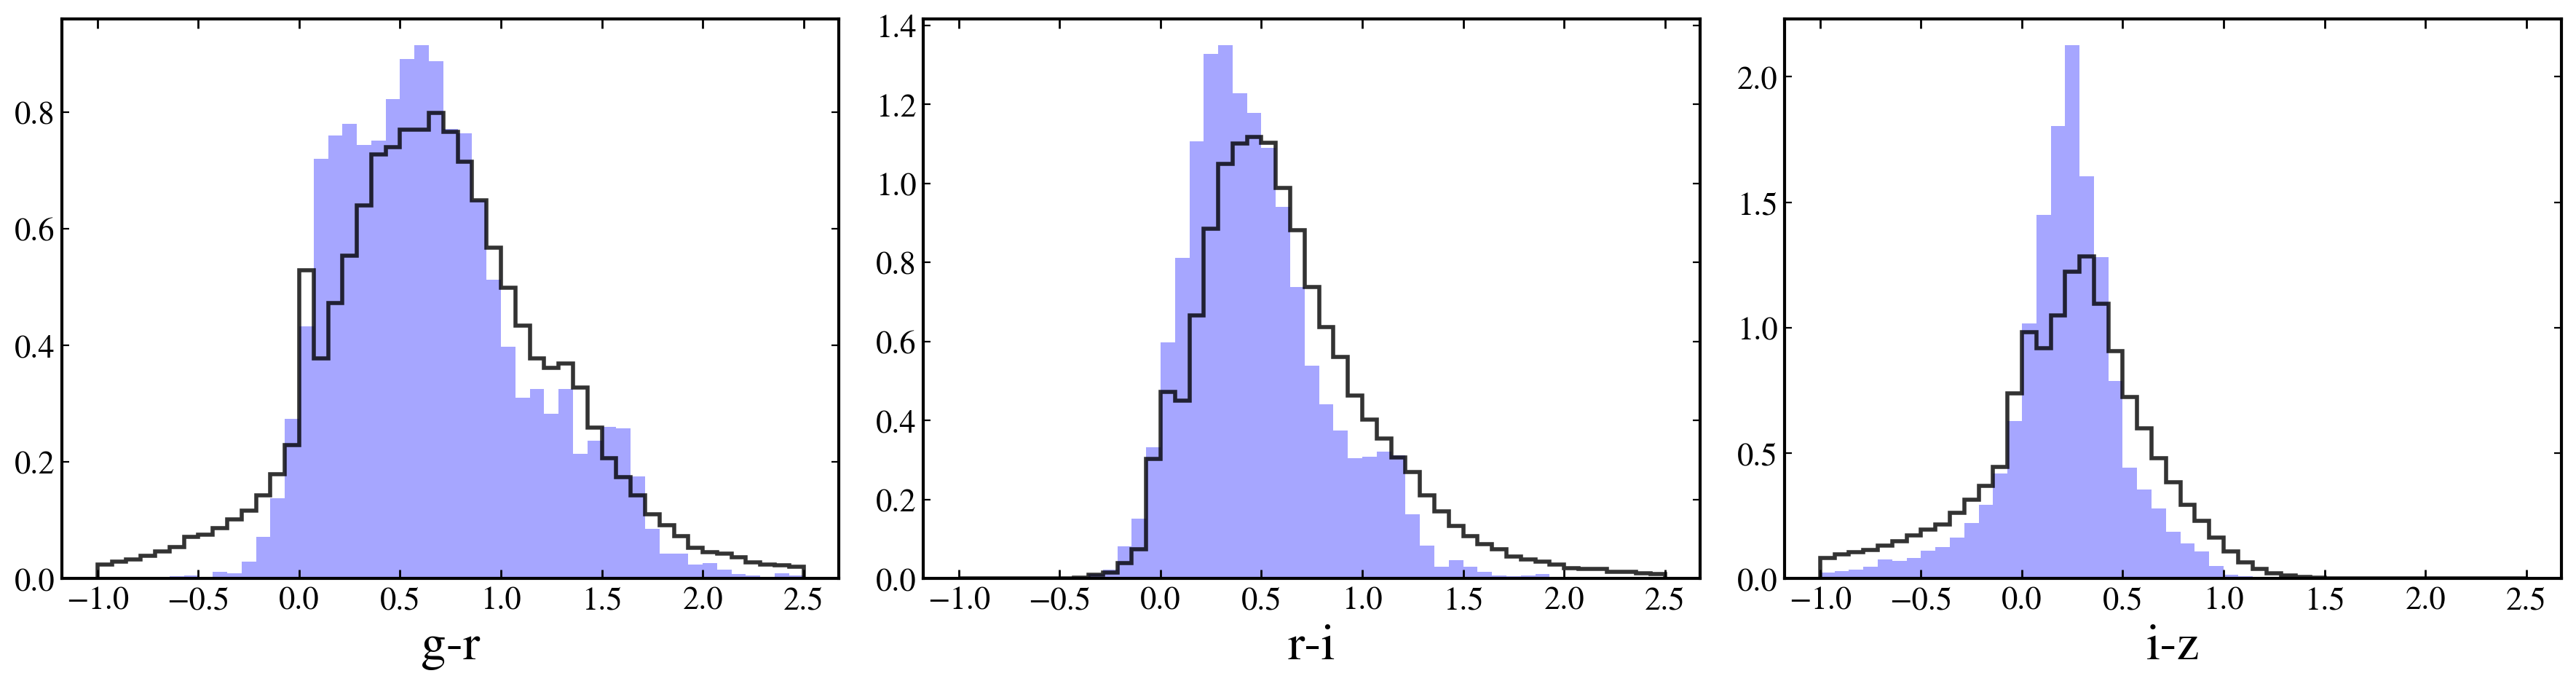

In [4]:
fig, axs = plt.subplots(1, 3, figsize=(18, 5))
magbins = np.linspace(14, 26.0, 52)
colorbins = np.linspace(-1, 2.5, 50)
bands = "griz"
for i in range(3):
    bandi = bands[i]
    bandj = bands[i + 1]
    xi = f"{bandi}_mag_gauss2"
    xj = f"{bandj}_mag_gauss2"
    axs[i].hist(df_train[xi] - df_train[xj], bins=colorbins, alpha=0.35, color="b", density=True)
    axs[i].hist(df[xi] - df[xj], bins=colorbins, alpha=0.8, color="k", density=True, histtype="step", linewidth=2.0)
    axs[i].set_xlabel(f"{bandi}-{bandj}", fontsize=25)
plt.tight_layout()

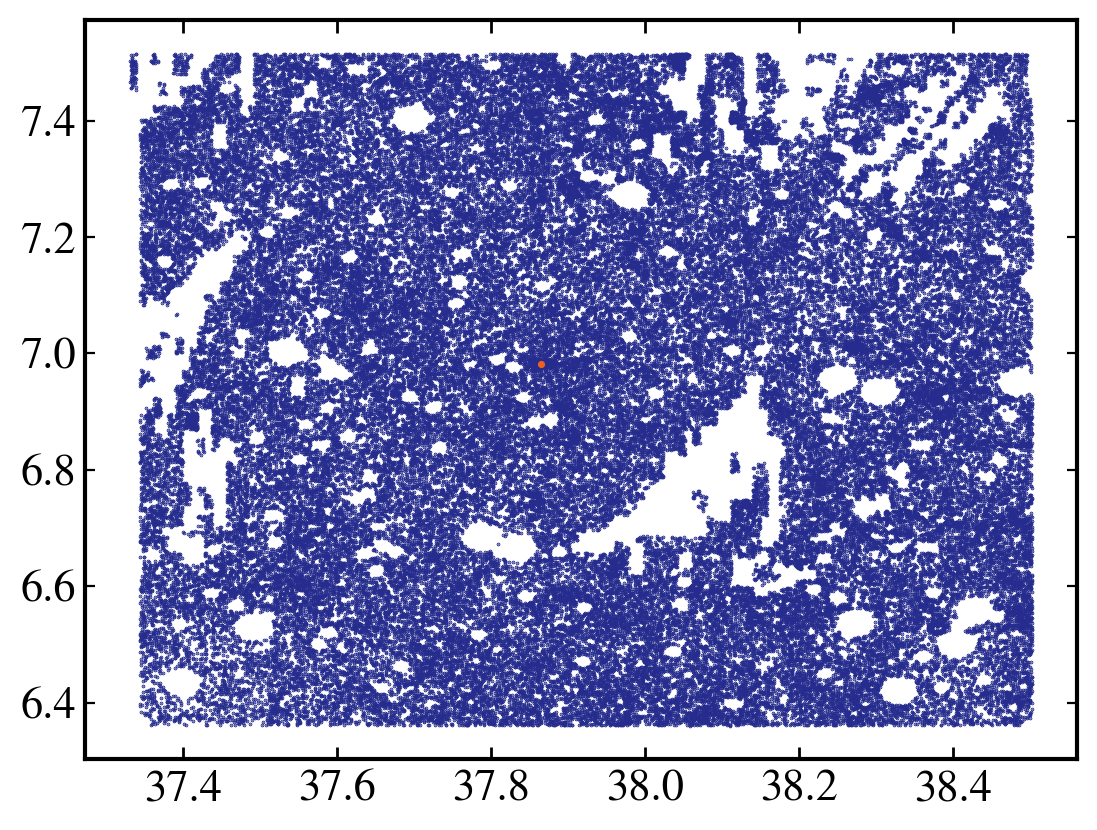

In [4]:
ra_bcg = cluster_coords[0]
dec_bcg = cluster_coords[1]
mm = (df["ra"] - 59.428) ** 2.0 + (df["dec"] + 48.908) ** 2.0 > 0.0015
plt.scatter(df["ra"][mm], df["dec"][mm], s=0.1)
plt.scatter(ra_bcg, dec_bcg, s=2.5)

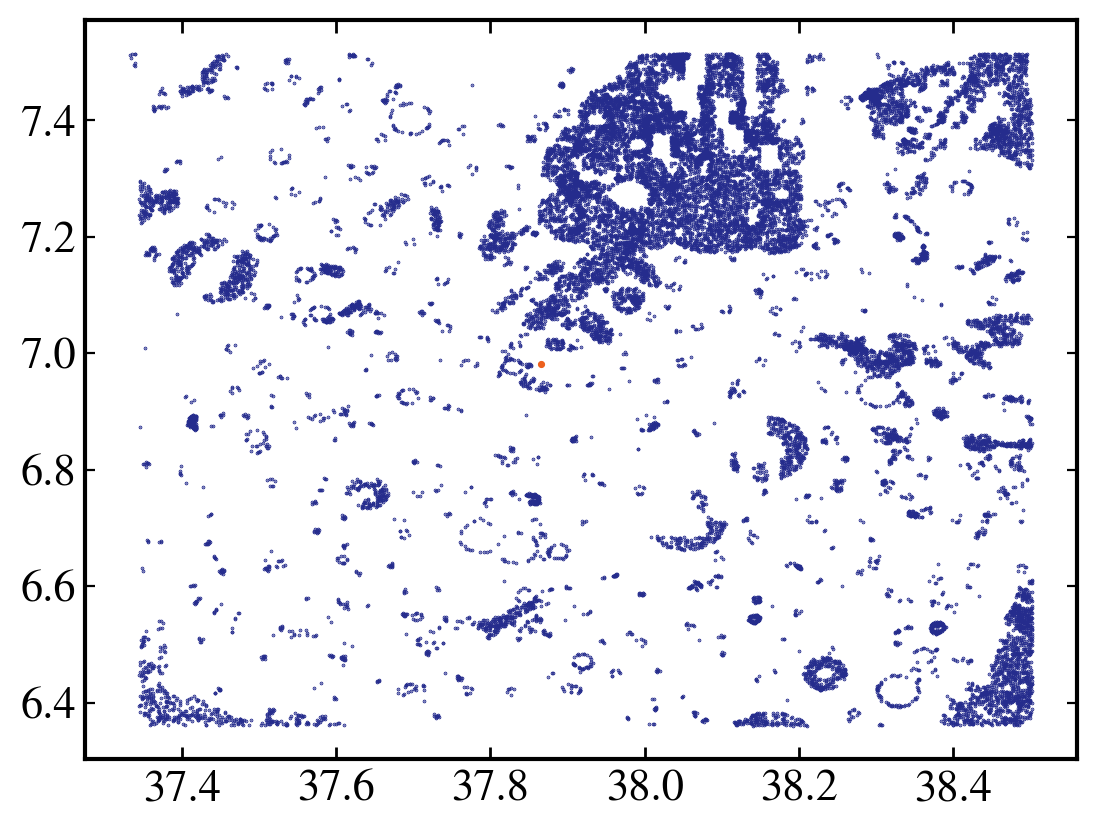

In [81]:
ra_bcg = cluster_coords[0]
dec_bcg = cluster_coords[1]
mm = (df["ra"] - 59.428) ** 2.0 + (df["dec"] + 48.908) ** 2.0 > 0.0015
plt.scatter(df["ra"][~hmask], df["dec"][~hmask], s=0.1)
plt.scatter(ra_bcg, dec_bcg, s=2.5)

In [9]:
zfname = os.path.join(Dir, "rail_data", "data_a360_redshift.hdf5")
pzfname = os.path.join(Dir, "rail_data", "data_a360_redshift_pdfs.fits")
if False:
    import xlens
    import pickle
    with open(MODEL_PATH, "rb") as f:
        pz_obj = pickle.load(f)
    fzbobj = xlens.catalog.redshift.flexzboostEstimator(pz_obj)
    redshift = fzbobj.get_z(
        df.as_array(),
        mag_zero=31.4,
        flux_name="gauss2",
        bands="griz",
        ref_band="i",
        return_pdfs=True,
    )
    pdfs = redshift["pdfs"]
    fitsio.write(pzfname, pdfs)
    d2 = {k: v for k, v in redshift.items() if k != "pdfs"}
    tables_io.write(d2, zfname)
    redshift = d2
else:
    redshift = tables_io.read(
        zfname,
        tType="astropyTable",
    )
    pdfs = fitsio.read(pzfname)

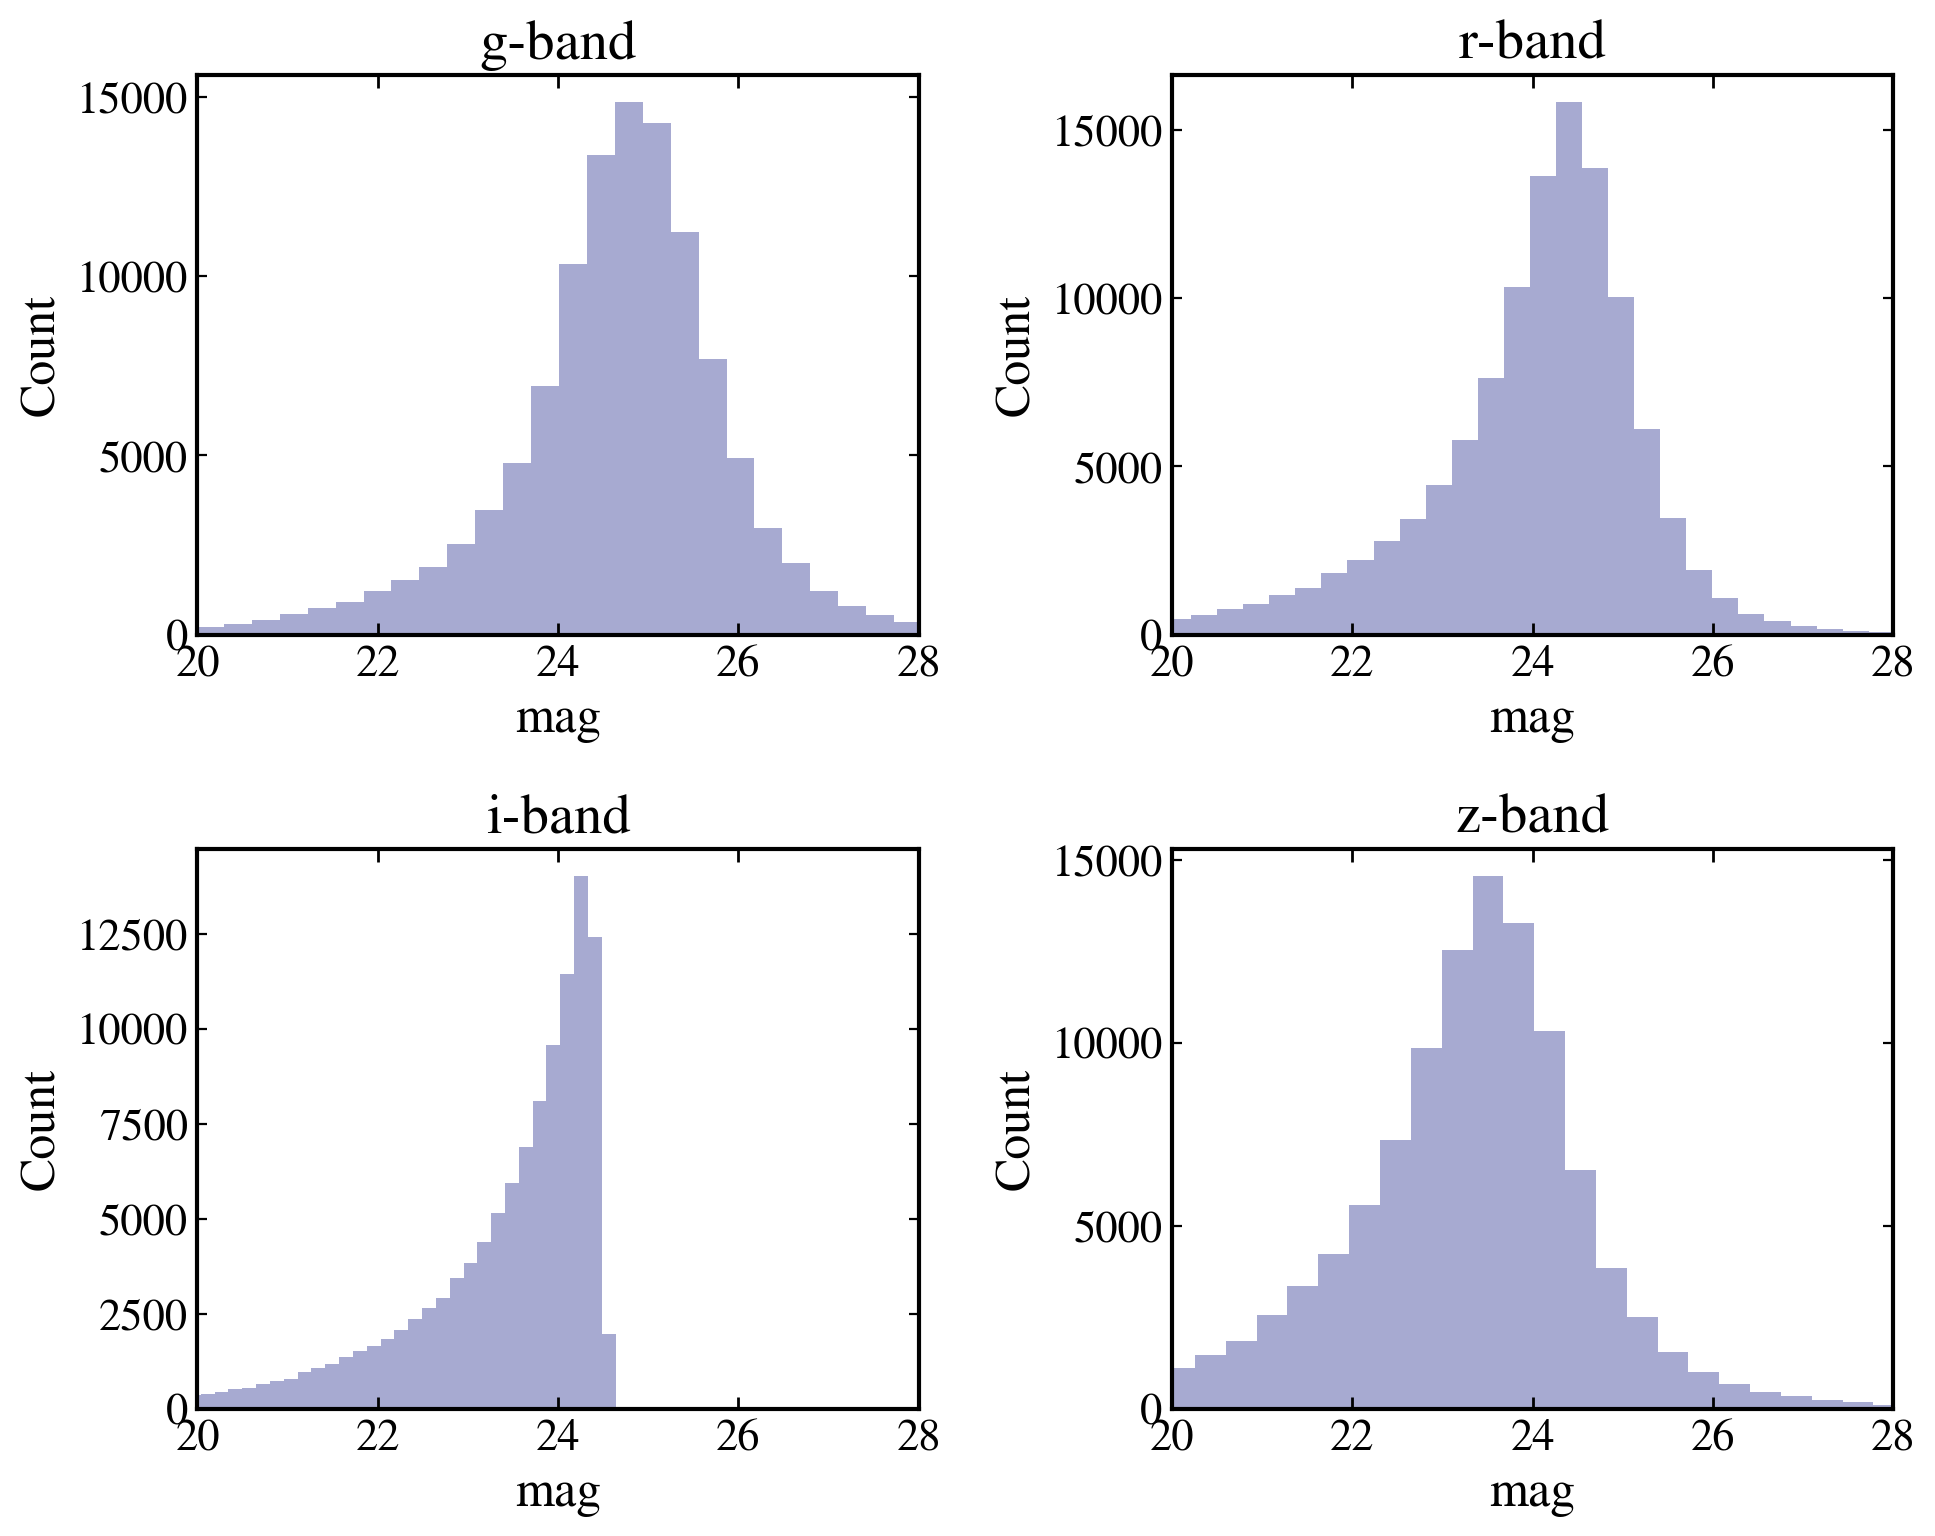

In [10]:
cols = ["g_mag_gauss2", "r_mag_gauss2", "i_mag_gauss2", "z_mag_gauss2"]
labels = ["g", "r", "i", "z"]

fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes = axes.ravel()

for ax, col, lab in zip(axes, cols, labels):
    x = df[col]
    x = x[np.isfinite(x)]  # drop NaN/inf
    ax.hist(x, bins=60, alpha=0.4)
    ax.set_title(f"{lab}-band")
    ax.set_xlabel("mag")
    ax.set_ylabel("Count")
    ax.set_xlim(20, 28)

fig.tight_layout()
plt.show()

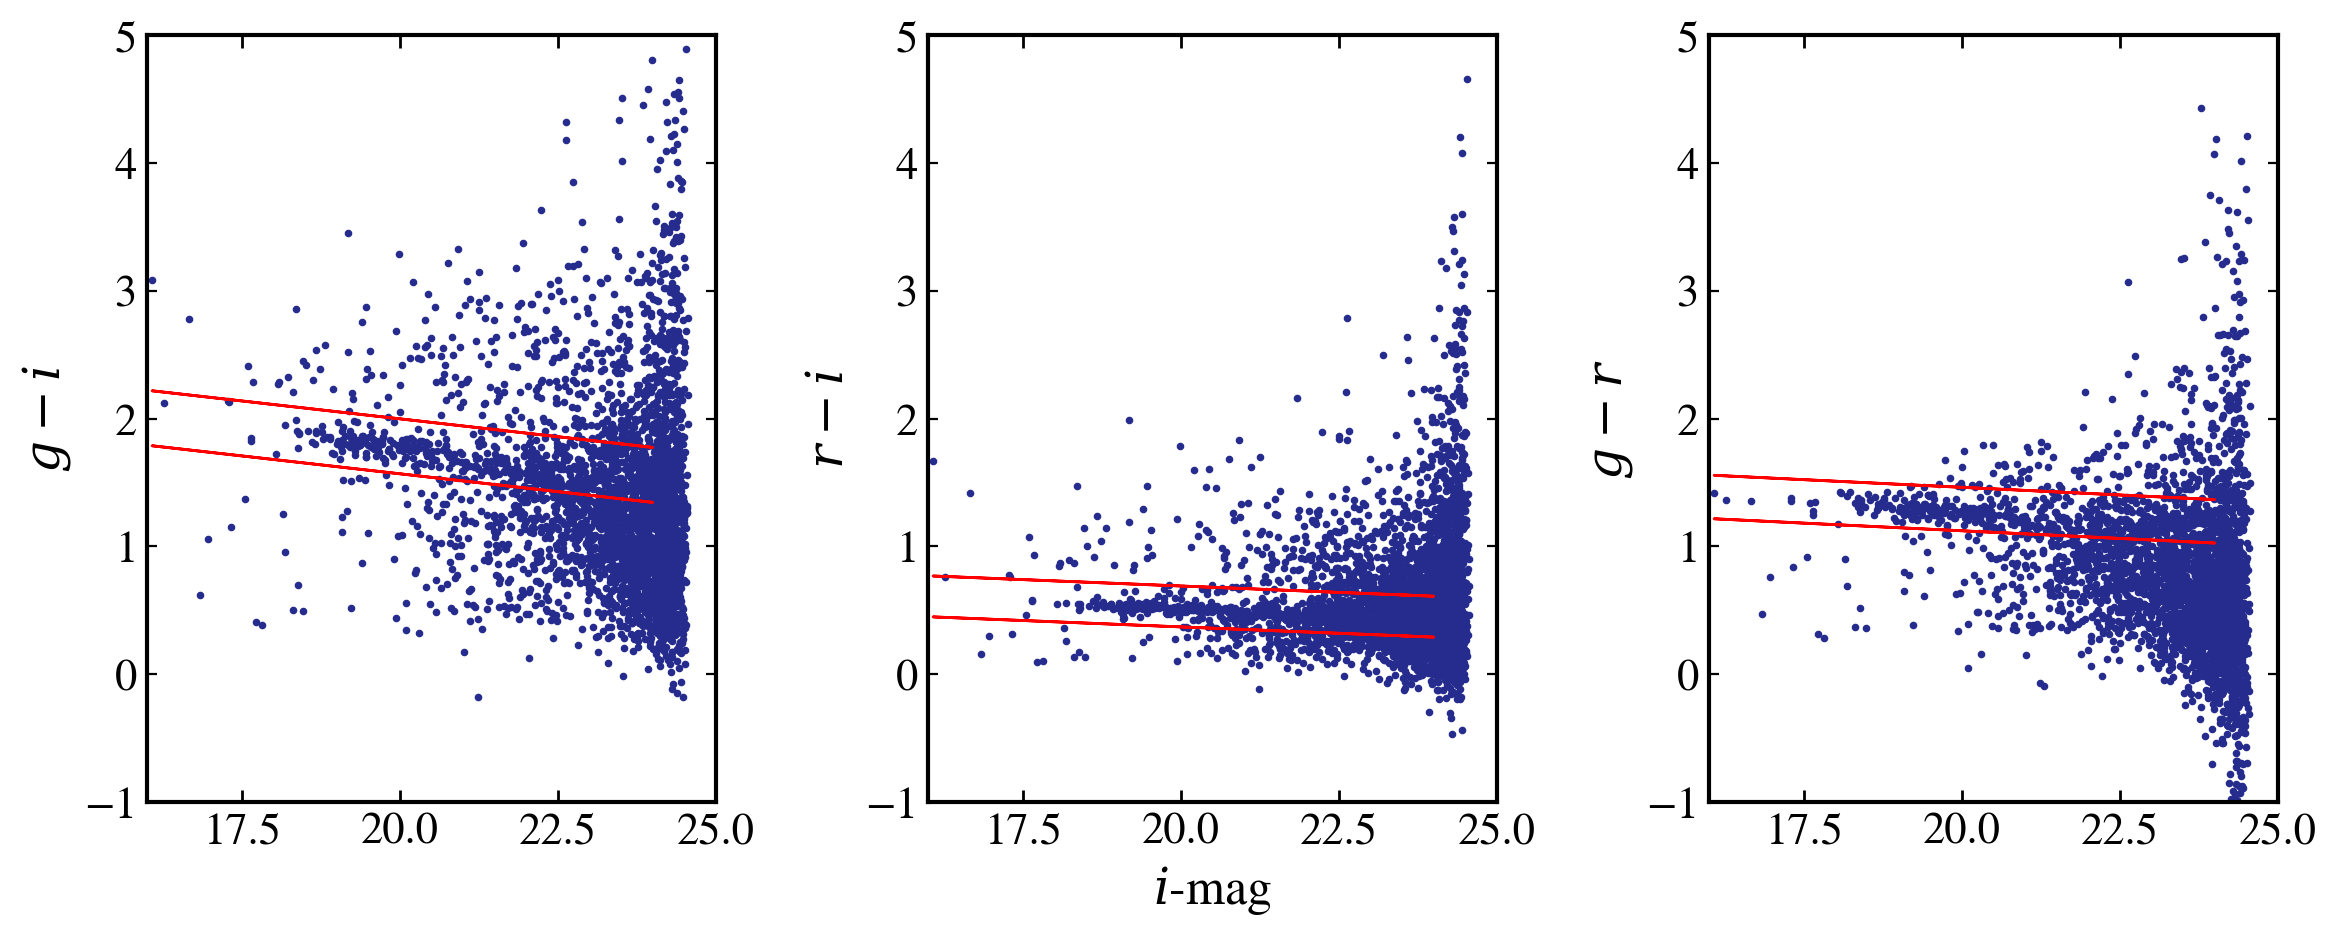

In [68]:
mag_lim = 24.0
gi_lims = (0.23, -0.20)
ri_lims = (0.15, -0.17)
gr_lims = (0.16, -0.18)
color_gi = df3['g_mag_gauss2'] - df3['i_mag_gauss2']
color_ri = df3['r_mag_gauss2'] - df3['i_mag_gauss2']
color_gr = df3['g_mag_gauss2'] - df3['r_mag_gauss2']
color_iz = df3['i_mag_gauss2'] - df3['z_mag_gauss2']
gi_line = (df3['i_mag_gauss2'] - 18) * (-0.28/5) + 1.88
ri_line = (df3['i_mag_gauss2'] - 18) * (-0.1/5) + .58
gr_line = (df3['i_mag_gauss2'] - 18) * (-0.12/5) + 1.35

gi_redseq = np.logical_and.reduce((
    color_gi < gi_line + gi_lims[0], 
    color_gi > gi_line + gi_lims[1], 
    df3['i_mag_gauss2'] < mag_lim
))
ri_redseq = np.logical_and.reduce((
    color_ri < ri_line + ri_lims[0], 
    color_ri > ri_line + ri_lims[1], 
    df3['i_mag_gauss2'] < mag_lim
))
gr_redseq = np.logical_and.reduce((
    color_gr < gr_line + gr_lims[0],
    color_gr > gr_line + gr_lims[1],
    df3['i_mag_gauss2'] < mag_lim
))

counts = gi_redseq.astype(int) + ri_redseq.astype(int) + gr_redseq.astype(int)

all_redseq = np.logical_and.reduce((gi_redseq, gr_redseq, ri_redseq))
aggro_redseq = np.logical_or.reduce((gi_redseq, gr_redseq, ri_redseq))
dist = np.sqrt(((df3['ra'] - cluster_coords[0]) * np.cos(np.deg2rad(cluster_coords[1])))**2 + (df3['dec'] - cluster_coords[1])**2)
mm = dist < 0.1


fig, axes = plt.subplots(1, 3, figsize=(12, 5), sharex=True)
# First panel: g - i vs r_mag_gauss2
mag = df3["i_mag_gauss2"]
axes[0].scatter(mag[mm], color_gi[mm], s=3.0)
axes[0].plot(mag[mm & (mag<mag_lim)], gi_line[mm & (mag<mag_lim)] + gi_lims[0], color='red', lw=1)
axes[0].plot(mag[mm & (mag<mag_lim)], gi_line[mm & (mag<mag_lim)] + gi_lims[1], color='red', lw=1)
axes[0].set_ylabel(r"$g - i$")
axes[0].set_xlim(16, 25)
axes[0].set_ylim(-1, 5)

# Second panel: r - i vs r_mag_gauss2
axes[1].scatter(mag[mm], color_ri[mm], s=3.0)
axes[1].plot(mag[mm & (mag<mag_lim)], ri_line[mm & (mag<mag_lim)] + ri_lims[0], color='red', lw=1)
axes[1].plot(mag[mm & (mag<mag_lim)], ri_line[mm & (mag<mag_lim)] + ri_lims[1], color='red', lw=1)
axes[1].set_xlabel(r"$i$-mag")
axes[1].set_ylabel(r"$r - i$")
axes[1].set_xlim(16, 25)
axes[1].set_ylim(-1, 5)

# Third panel: g - r vs r_mag_gauss2
axes[2].scatter(mag[mm], color_gr[mm], s=3.0)
axes[2].plot(mag[mm & (mag<mag_lim)], gr_line[mm & (mag<mag_lim)] + gr_lims[0], color='red', lw=1)
axes[2].plot(mag[mm & (mag<mag_lim)], gr_line[mm & (mag<mag_lim)] + gr_lims[1], color='red', lw=1)
axes[2].set_ylabel(r"$g - r$")
axes[2].set_xlim(16, 25)
axes[2].set_ylim(-1, 5)

plt.tight_layout()
plt.show()

In [82]:
msk = (
    (df["g_mag_gauss2"] < 27.5) # basic cut for reliable photo-z estimation
    & (df["r_mag_gauss2"] < 27.5) # basic cut for reliable photo-z estimation
    & (df["i_mag_gauss2"] < 23.5) # main magnitude cut
    & (df["z_mag_gauss2"] < 27.5) # basic cut for reliable photo-z estimation
    & ((df["i_fpfs1_m00"] + df["i_fpfs1_m20"]) / df["i_fpfs1_m00"] > 0.10)
    & (redshift["zbest"] > 0.37)
    & ~(counts>=3)
    # & hmask
)
df2 = df[msk]

In [83]:
c0 = 50.0
weights = {
    "g": 0.10110928,
    "r": 0.290752, 
    "i": 0.51740466 , 
    "z": 0.09073406,
}
m22c = np.zeros(len(df2))
dm22c_dg1 = np.zeros(len(df2))
m22s = np.zeros(len(df2))
dm22s_dg2 = np.zeros(len(df2))
m00 = np.zeros(len(df2))
dm00_dg1 = np.zeros(len(df2))
dm00_dg2 = np.zeros(len(df2))
for band in ["g", "r", "i", "z"]:
    w = weights[band]
    m22c = m22c + df2[f"{band}_fpfs1_m22c"] * w
    m22s = m22s + df2[f"{band}_fpfs1_m22s"] * w
    m00 = m00 + df2[f"{band}_fpfs1_m00"] * w
    dm22c_dg1 = dm22c_dg1 + df2[f"{band}_fpfs1_dm22c_dg1"] * w
    dm22s_dg2 = dm22s_dg2 + df2[f"{band}_fpfs1_dm22s_dg2"] * w
    dm00_dg1 = dm00_dg1 + df2[f"{band}_fpfs1_dm00_dg1"] * w
    dm00_dg2 = dm00_dg2 + df2[f"{band}_fpfs1_dm00_dg2"] * w
e1 = m22c / (m00 + c0) * df2["wsel"]
e2 = m22s / (m00 + c0) * df2["wsel"]
de1_dg1 = dm22c_dg1 / (m00 + c0) - m22c / (m00 + c0)**2.0 * dm00_dg1
de2_dg2 = dm22s_dg2 / (m00 + c0) - m22s / (m00 + c0)**2.0 * dm00_dg2
res = (
    de1_dg1 * df2["wsel"] + df2["dwsel_dg1"]* m22c / (m00 + c0) +
    de2_dg2 * df2["wsel"] + df2["dwsel_dg2"]* m22s / (m00 + c0)
) / 2.0

In [84]:
def fast_bootstrap_mean(data, ci_level=0.95):
    from scipy.stats import bootstrap
    data = np.asarray(data)
    if data.ndim != 1:
        raise ValueError("Input data must be 1D")

    res = bootstrap(
        (data,),
        np.mean,
        confidence_level=ci_level,
    )
    return np.array([res.confidence_interval.low, res.confidence_interval.high])
    
def anacal_get_tang_cross(cluster, sky_dist, bins, R, ci_level=.95):
    nb = len(bins) - 1
    res_avg = np.zeros(nb)
    res_err = np.zeros((nb, 2))
    
    tang_avg = np.zeros(nb)
    cross_avg = np.zeros_like(tang_avg)

    tang_err = np.zeros((nb, 2))
    cross_err = np.zeros_like(tang_err)

    bin_rs = []
    R_correction2 = np.mean(R) - 0.01118
    print(R_correction2)
    
    for i in range(nb):
        # bin_rs.append(bins[i])
        ndx_filt = (sky_dist > bins[i]) * (sky_dist < bins[i+1])
        bin_rs.append(np.where(ndx_filt)[0])
        if np.sum(ndx_filt) < 1:
            continue
            
        sample = cluster[ndx_filt]
        sample_t = sample.real
        sample_x = sample.imag

        sr = R[ndx_filt] 
        R_correction = np.mean(sr)
        ta = np.mean(sample_t) / R_correction2
        xa = np.mean(sample_x) / R_correction2
        
        re = fast_bootstrap_mean(sr, ci_level=ci_level)
        te = fast_bootstrap_mean(sample_t, ci_level=ci_level)
        xe = fast_bootstrap_mean(sample_x, ci_level=ci_level)
        
        res_avg[i] = R_correction
        res_err[i] = re
        tang_avg[i] = ta
        cross_avg[i] = xa
        tang_err[i] = te / R_correction2
        cross_err[i] = xe / R_correction2
        print(np.sum(ndx_filt))
    return tang_avg, cross_avg, tang_err, cross_err, bin_rs, res_avg, res_err
    
source_phi = np.arctan2(df2['dec'] - cluster_coords[1], (cluster_coords[0] - df2['ra'])*np.cos(np.deg2rad(cluster_coords[1])))
ang_dist = np.sqrt(((df2['ra'] - cluster_coords[0]) * np.cos(np.deg2rad(cluster_coords[1])))**2 + (df2['dec'] - cluster_coords[1])**2)
sky_distance = Da(.22) * ang_dist * (np.pi/180)

trial_shear = e1 + 1.j*e2
cl_shear = trial_shear * -1*np.exp(-2j*source_phi)

#bins_mpc = clmm.make_bins(0.5,6.0,nbins=7, method='evenlog10width')
bins_mpc = np.array([0.3, 0.7       , 1.06495522, 1.62018517, 2.46489237, 3.75    , 5, 6 ])
bin_mids = 1/2 * (bins_mpc[1:] + bins_mpc[:-1])
shear_cl = anacal_get_tang_cross(cl_shear, sky_distance, bins_mpc, res, ci_level=.68)
moo = clmm.Modeling(massdef="critical", delta_mdef=500, halo_profile_model="nfw")
moo.set_cosmo(cosmo)
moo.set_concentration(4)
moo.set_mass(6e14)
gt_z = moo.eval_reduced_tangential_shear(
    rproj, z_cl, [beta_s_mean, beta_s_square_mean], z_src_info="beta", approx="order2"
)

0.3239336326558003
160
285
582
1418
2821
3380
4053


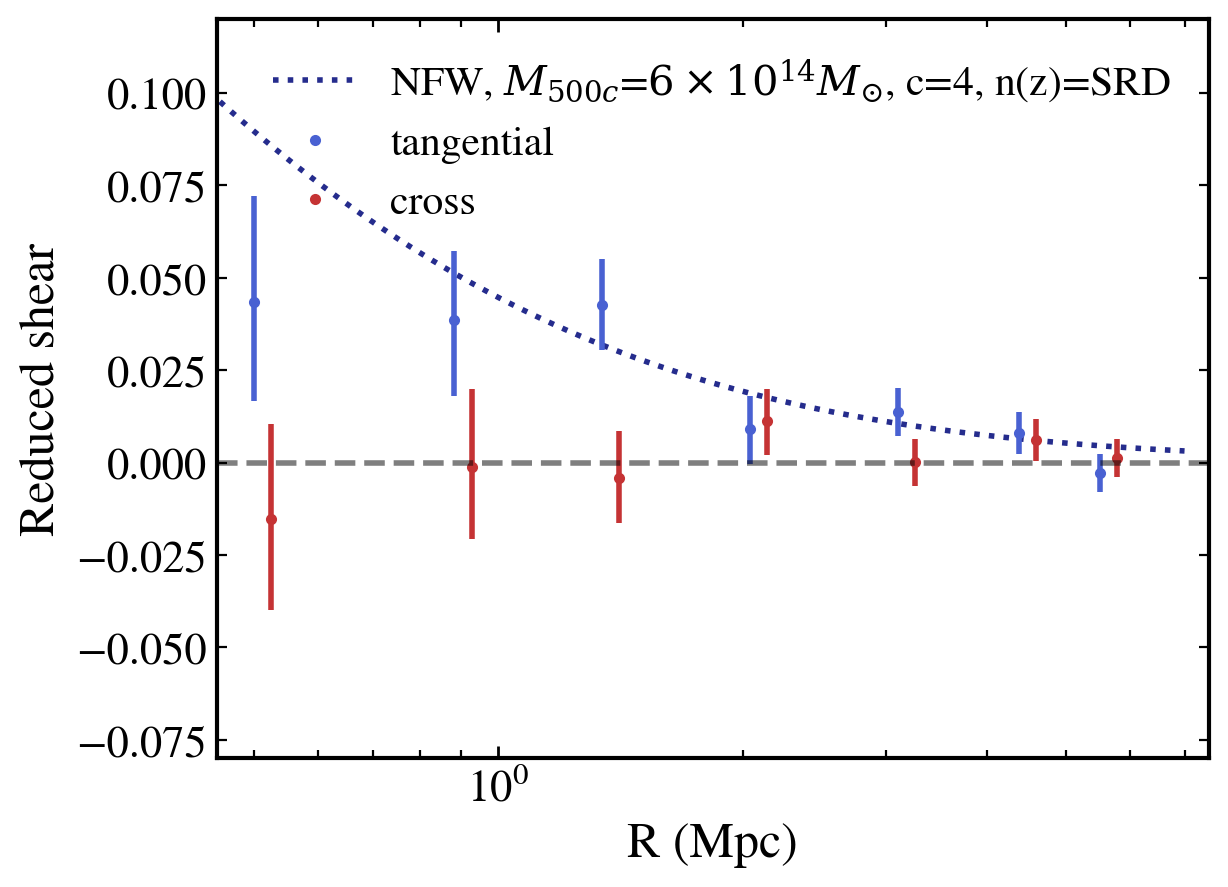

In [85]:
plt.close()
cmap = cm.coolwarm

plt.plot(rproj, gt_z, label=r'NFW, $M_{500c}$=$6 \times 10^{14} M_{\odot}$, c=4, n(z)=SRD', ls=':')
plt.plot(bin_mids, shear_cl[0], '.', label='tangential', color=cmap(.05))
plt.vlines(bin_mids, shear_cl[2][:,0], shear_cl[2][:,1], color=cmap(0.05))

plt.plot(1.05*bin_mids, shear_cl[1], '.', label='cross', color=cmap(.95))
plt.vlines(1.05*bin_mids, shear_cl[3][:,0], shear_cl[3][:,1], color=cmap(0.95))
chi2_t = np.sum(shear_cl[0] ** 2.0 / ((shear_cl[2][:,0] - shear_cl[2][:,1]) / 2.0) ** 2.0)
chi2_x = np.sum(shear_cl[1] ** 2.0 / ((shear_cl[3][:,0] - shear_cl[3][:,1]) / 2.0) ** 2.0)

plt.semilogx()
plt.axhline(0, ls='--', color='k', alpha=.5)

plt.ylim([-0.08,0.12])
plt.xlim([0.45,7.5])
plt.ylabel("Reduced shear")
plt.xlabel("R (Mpc)")
plt.legend(frameon=False, loc='upper right', fontsize=15)

In [80]:
print(np.sqrt(chi2_t))
print(np.sqrt(chi2_x))

5.338870474777389
1.2437816076404515


In [56]:
import scipy
print(scipy.stats.chi2.sf(chi2_t, 7))
print(scipy.stats.chi2.sf(chi2_x, 7))

0.00021272416603215126
0.9797538866741949


# Selection bias correction

In [57]:
zfname_1p = os.path.join(Dir, "rail_data", "data_a360_redshift_1p.hdf5")
zfname_1m = os.path.join(Dir, "rail_data", "data_a360_redshift_1m.hdf5")
if False:
    import xlens
    import pickle
    with open(MODEL_PATH, "rb") as f:
        pz_obj = pickle.load(f)
    fzbobj = xlens.catalog.redshift.flexzboostEstimator(pz_obj)

    # Ensure df supports .as_array(); if it's pandas, switch to df.to_records(index=False)
    x = df.as_array()
    out = {}
    for tag, dg, fname in [("1p", 0.02, zfname_1p), ("1m", -0.02, zfname_1m)]:
        rz = fzbobj.get_z(
            x,
            mag_zero=31.4,
            flux_name="gauss2",
            bands="griz",
            ref_band="i",
            return_pdfs=False,
            dg=dg,
        )
        rz = {k: v for k, v in rz.items() if k != "pdfs"}
        tables_io.write(rz, fname)
        out[tag] = rz
    redshift_1p = out["1p"]
    redshift_1m = out["1m"]
else:
    redshift_1p = tables_io.read(
        zfname_1p,
        tType="astropyTable",
    )
    redshift_1m = tables_io.read(
        zfname_1m,
        tType="astropyTable",
    )

In [86]:
# --- build perturbed mags per band ---
bands = ["g", "r", "i", "z"]
dg0 = 0.02

mags_1p = {}
mags_1m = {}
for b in bands:
    mags_1p[b] = 31.4 - 2.5 * np.log10(df[f"{b}_flux_gauss2"] + df[f"{b}_dflux_gauss2_dg1"] * dg0)
    mags_1m[b] = 31.4 - 2.5 * np.log10(df[f"{b}_flux_gauss2"] - df[f"{b}_dflux_gauss2_dg1"] * dg0)
trace_1p = (df["i_fpfs1_m00"] + df["i_fpfs1_m20"] + dg0 * (df["i_fpfs1_dm00_dg1"] + df["i_fpfs1_dm20_dg1"])) / (df["i_fpfs1_m00"] + dg0 * df["i_fpfs1_dm00_dg1"])
trace_1m = (df["i_fpfs1_m00"] + df["i_fpfs1_m20"] - dg0 * (df["i_fpfs1_dm00_dg1"] + df["i_fpfs1_dm20_dg1"])) / (df["i_fpfs1_m00"] - dg0 * df["i_fpfs1_dm00_dg1"])

def redseq_counts(g_mag, r_mag, i_mag):
    color_gi = g_mag - i_mag
    color_ri = r_mag - i_mag
    color_gr = g_mag - r_mag

    gi_line = (i_mag - 18) * (-0.26/5) + 1.88
    ri_line = (i_mag - 18) * (-0.1/5) + 0.58
    gr_line = (i_mag - 18) * (-0.12/5) + 1.35

    gi_redseq = np.logical_and.reduce((
        color_gi < gi_line + gi_lims[0],
        color_gi > gi_line + gi_lims[1],
        i_mag < mag_lim
    ))
    ri_redseq = np.logical_and.reduce((
        color_ri < ri_line + ri_lims[0],
        color_ri > ri_line + ri_lims[1],
        i_mag < mag_lim
    ))
    gr_redseq = np.logical_and.reduce((
        color_gr < gr_line + gr_lims[0],
        color_gr > gr_line + gr_lims[1],
        i_mag < mag_lim
    ))

    return gi_redseq.astype(int) + ri_redseq.astype(int) + gr_redseq.astype(int)

counts_1p = redseq_counts(mags_1p["g"], mags_1p["r"], mags_1p["i"])
counts_1m = redseq_counts(mags_1m["g"], mags_1m["r"], mags_1m["i"])

# ---- final masks ----
msk_1p = (
    (mags_1p["g"] < 27.5) &
    (mags_1p["r"] < 27.5) &
    (mags_1p["i"] < 23.5) &
    (mags_1p["z"] < 27.5) &
    (trace_1p > 0.10) &
    (redshift_1p["zbest"] > 0.37) &
    ~(counts_1p >= 3)
)

msk_1m = (
    (mags_1m["g"] < 27.5) &
    (mags_1m["r"] < 27.5) &
    (mags_1m["i"] < 23.5) &
    (mags_1m["z"] < 27.5) &
    (trace_1m > 0.10) &
    (redshift_1m["zbest"] > 0.37) &
    ~(counts_1m >= 3)
)

df2_1p = df[msk_1p]
df2_1m = df[msk_1m]

/tmp/ipykernel_448452/1706991502.py:8: RuntimeWarning: invalid value encountered in log10
  mags_1p[b] = 31.4 - 2.5 * np.log10(df[f"{b}_flux_gauss2"] + df[f"{b}_dflux_gauss2_dg1"] * dg0)
/tmp/ipykernel_448452/1706991502.py:9: RuntimeWarning: invalid value encountered in log10
  mags_1m[b] = 31.4 - 2.5 * np.log10(df[f"{b}_flux_gauss2"] - df[f"{b}_dflux_gauss2_dg1"] * dg0)


In [87]:
def compute_e1_means(df2, weights, c0, bands=("g","r","i","z")):
    n = len(df2)
    m22c = np.zeros(n, dtype=float)
    m22s = np.zeros(n, dtype=float)
    m00  = np.zeros(n, dtype=float)

    for band in bands:
        w = weights[band]
        m22c += np.asarray(df2[f"{band}_fpfs1_m22c"], dtype=float) * w
        m22s += np.asarray(df2[f"{band}_fpfs1_m22s"], dtype=float) * w
        m00  += np.asarray(df2[f"{band}_fpfs1_m00"],  dtype=float) * w

    denom = m00 + c0
    wsel  = np.asarray(df2["wsel"], dtype=float)

    e1_raw = m22c / denom
    e2_raw = m22s / denom
    e1 = e1_raw * wsel
    e2 = e2_raw * wsel
    return np.mean(e1_raw * wsel)

# --- apply to your two catalogs ---
e1_1p = compute_e1_means(df2_1p, weights=weights, c0=c0)
e1_1m = compute_e1_means(df2_1m, weights=weights, c0=c0)
R_sel = (e1_1p - e1_1m) / dg0 / 2.0

In [88]:
R_sel

np.float64(-0.00999229236913263)